# Simple Strategy Notebook

Welcome to the Simple Strategy Notebook.<br>
In this notebook we are going to explore a simple strategy to trade an asset using sentiment data from `reddit` comments.<br>

**Quick overview of the data**:
The data consists of a `.csv` file with the following columns:
date;avg_sentiment;submission_count;Open;High;Low;Close;Adj Close;Volume
- **date**: the date with format `YYYY-MM-DD`
- **avg_sentiment**: the average sentiment of the comments in the subreddit on that specific day
- **submission_count**: the number of submissions in the subreddit on that specific day related to the asset
- **Open**: the opening price of the asset on that specific day
- **High**: the highest price of the asset on that specific day
- **Low**: the lowest price of the asset on that specific day
- **Close**: the closing price of the asset on that specific day
- **Adj Close**: the adjusted closing price of the asset on that specific day
- **Volume**: the volume of the asset on that specific day

**Objective**:
The objective of this notebook is to create a simple strategy to trade an asset using the sentiment data from `reddit` comments. The strategy should be simple and easy to understand.

**Strategy**:
The strategy is simple and consists of the following steps:
Our study is always done on a window of 3 days.
1. If the average sentiment variance is higher than a certain threshold, we buy the asset.
2. If the average sentiment variance is lower than a certain threshold, we sell the asset.
3. If the average sentiment variance is between the buy and sell thresholds, we hold the asset.

## Table of Contents
1. [Importing the Libraries](#1.-Importing-the-Libraries)
2. [Exploratory Data Analysis](#3.-Exploratory-Data-Analysis)
3. [Creating the Strategy](#4.-Creating-the-Strategy)
4. [Backtesting the Strategy](#5.-Backtesting-the-Strategy)
5. [Conclusion](#6.-Conclusion)

## 1. Importing the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2. Exploratory Data Analysis

### 2.1 Load the Data

In [32]:
asset_data = pd.read_csv('Data/final/amzn_data_bis.csv', sep=';')

# sorting the data by date
asset_data = asset_data.sort_values(by='date')
# reset the index
asset_data = asset_data.reset_index(drop=True)
# presenting the data
asset_data.head()

,date,avg_sentiment,submission_count,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,0.0,1,37.896000,37.938000,37.384998,37.683498,37.683498,70422000
1,2017-01-04,0.0,1,37.919498,37.984001,37.709999,37.859001,37.859001,50210000
2,2017-01-05,0.5,4,38.077499,39.119999,38.013000,39.022499,39.022499,116602000
3,2017-01-06,0.0,2,39.118000,39.972000,38.924000,39.799500,39.799500,119724000
4,2017-01-09,0.0,1,39.900002,40.088501,39.588501,39.846001,39.846001,68922000


### 2.2 Data Processing/Feature Engineering

In [33]:
# 3-day rolling variance of the average sentiment
asset_data['sentiment_rolling_var'] = asset_data['avg_sentiment'].rolling(window=3).var()
# drop the resulting NaN values
asset_data = asset_data.dropna()

### 2.3 Data Splitting (Train and Test)

In [34]:
# Splitting the dataset into training and testing sets (first 80% of data for training, last 20% for testing)
train_size = int(0.6 * asset_data.shape[0])
train_df = asset_data.iloc[:train_size]
test_df = asset_data.iloc[train_size:]

## 3. Creating the Strategy

### 3.1 Finding Optimal Thresholds

All the above sections are relatively straightforward<br>
Now we move on to the strategy creation section.<br>
Our trading strategy is based on finding the **optimal thresholds** for buying and selling the asset.<br>

We will use the `train` data to find the optimal thresholds.<br>
Using a **Bayesian Optimization** technique, we will find the optimal thresholds for buying and selling the asset.<br>

In [35]:
from bayes_opt import BayesianOptimization

In [36]:
## Helper functions

def apply_strategy_with_thresholds(df, buy_threshold, sell_threshold):
    df['signal'] = 0  # Default to hold
    df.loc[df['sentiment_rolling_var'] > buy_threshold, 'signal'] = 1  # Buy
    df.loc[df['sentiment_rolling_var'] < sell_threshold, 'signal'] = -1  # Sell
    return df

def backtest_with_thresholds(df):
    # Calculate daily returns
    df['Return'] = df['Close'].pct_change()

    # Calculate strategy returns
    df['strategy_return'] = df['signal'].shift(1) * df['Return']

    # Calculate cumulative returns
    df['cumulative_strategy_return'] = (1 + df['strategy_return']).cumprod()

    return df

def evaluate_strategy_with_thresholds(buy_threshold, sell_threshold):
    df = train_df.copy()
    
    df = apply_strategy_with_thresholds(df, buy_threshold, sell_threshold)
    df = backtest_with_thresholds(df)
    
    sharpe_ratio = df['strategy_return'].mean() / df['strategy_return'].std() * (252**0.5)
    return sharpe_ratio

In [37]:
# Defining the bounds for the thresholds
pbounds = {
    'buy_threshold': (train_df['sentiment_rolling_var'].quantile(0.5), train_df['sentiment_rolling_var'].quantile(0.95)),
    'sell_threshold': (train_df['sentiment_rolling_var'].quantile(0.05), train_df['sentiment_rolling_var'].quantile(0.5))
}

# Initializing the Bayesian Optimizer
optimizer = BayesianOptimization(
    f=evaluate_strategy_with_thresholds,
    pbounds=pbounds,
    random_state=42
)

In [38]:
# Performing optimization
optimizer.maximize(
    init_points=10,  # Number of random points to evaluate before starting the optimization
    n_iter=30  # Number of iterations of the optimization
)

# Getting the best thresholds
best_params = optimizer.max['params']
best_buy_threshold = best_params['buy_threshold']
best_sell_threshold = best_params['sell_threshold']

print(f'Best Buy Threshold: {best_buy_threshold}')
print(f'Best Sell Threshold: {best_sell_threshold}')


|   iter    |  target   | buy_th... | sell_t... |
-------------------------------------------------
| 1         | -0.9086   | 0.1218    | 0.03528   |
| 2         | -1.024    | 0.2026    | 0.02274   |
| 3         | 0.5634    | 0.07233   | 0.006978  |
| 4         | -0.406    | 0.05018   | 0.03227   |
| 5         | -1.215    | 0.173     | 0.02664   |
| 6         | -0.3333   | 0.04169   | 0.03597   |
| 7         | -0.2402   | 0.2254    | 0.008985  |
| 8         | 0.6341    | 0.07817   | 0.007954  |
| 9         | -0.4878   | 0.1059    | 0.02011   |
| 10        | -0.4878   | 0.1348    | 0.01179   |
| 11        | 0.5903    | 0.07227   | 0.007271  |
| 12        | -0.3711   | 0.07585   | 0.02209   |
| 13        | -0.1813   | 0.06294   | 0.01213   |
| 14        | 0.1507    | 0.088     | 0.008015  |
| 15        | -0.2011   | 0.07511   | 0.01263   |
| 16        | 1.013     | 0.08093   | 0.003959  |
| 17        | 0.8144    | 0.08479   | 0.001584  |
| 18        | 1.213     | 0.07843   | 0.001422  |


## 4. Backtesting the Strategy

### 4.1 Applying the Strategy on the Test Data

In [39]:
# Apply the strategy with the optimal thresholds
train_df = apply_strategy_with_thresholds(train_df, best_buy_threshold, best_sell_threshold)
test_df = apply_strategy_with_thresholds(test_df, best_buy_threshold, best_sell_threshold)

# Backtest the strategy
train_df = backtest_with_thresholds(train_df)
test_df = backtest_with_thresholds(test_df)

/var/folders/zj/sr110gkn1vz4qf70llfwlh8c0000gn/T/ipykernel_19124/791920302.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'] = 0  # Default to hold
/var/folders/zj/sr110gkn1vz4qf70llfwlh8c0000gn/T/ipykernel_19124/791920302.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'] = 0  # Default to hold
/var/folders/zj/sr110gkn1vz4qf70llfwlh8c0000gn/T/ipykernel_19124/791920302.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

### 4.2 Evaluating the Strategy

In [40]:
## Helper function
def evaluate_performance(df):
    sharpe_ratio = df['strategy_return'].mean() / df['strategy_return'].std() * (252**0.5)
    max_drawdown = (df['cumulative_strategy_return'].cummax() - df['cumulative_strategy_return']).max()
    cumulative_return = df['cumulative_strategy_return'].iloc[-1]
    print(f'Sharpe Ratio: {sharpe_ratio}')
    print(f'Max Drawdown: {max_drawdown}')
    print(f'Cumulative Return: {cumulative_return}')

In [41]:
# Evaluate performance on both training and test sets
print("Training Set Performance:")
evaluate_performance(train_df)

print("\nTest Set Performance:")
evaluate_performance(test_df)

Training Set Performance:
Sharpe Ratio: 1.213441274021681
Max Drawdown: 0.19595611016880077
Cumulative Return: 1.7932658482978177

Test Set Performance:
Sharpe Ratio: 0.02735451863653337
Max Drawdown: 0.1821921101036672
Cumulative Return: 0.9711004794114958


### 4.3 Visualizing the Strategy

In [42]:
import matplotlib.pyplot as plt

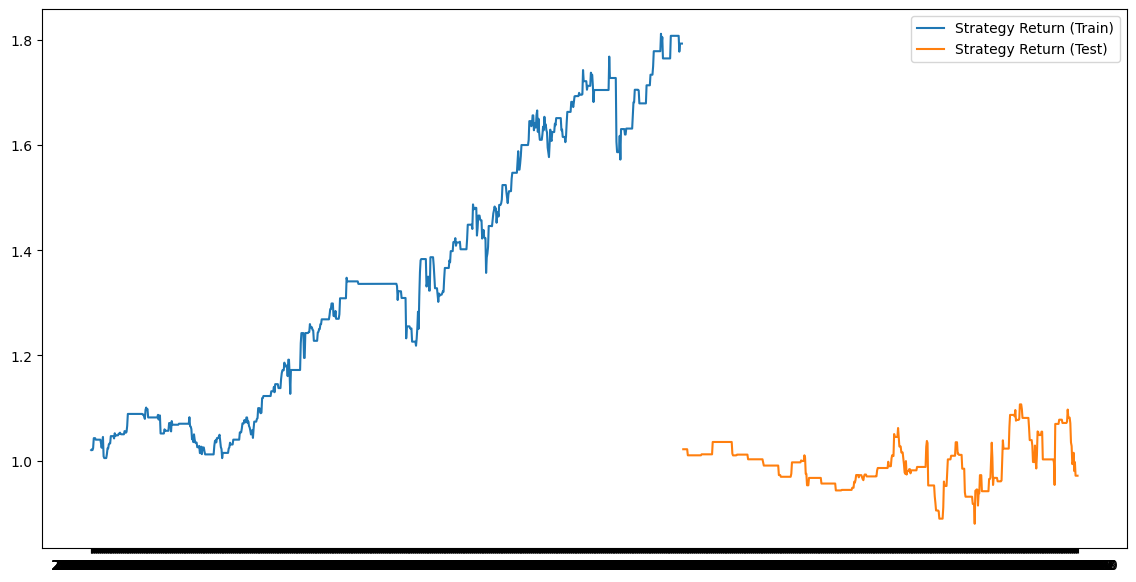

In [43]:
# Plot the cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(train_df['date'], train_df['cumulative_strategy_return'], label='Strategy Return (Train)')
plt.plot(test_df['date'], test_df['cumulative_strategy_return'], label='Strategy Return (Test)')
plt.legend()
plt.show()

In [ ]:
import pandas as pd

# Load the data from the CSV file
data = pd.read_csv('data.csv')

# Define the buy and sell thresholds
buy_threshold = 0.5
sell_threshold = 0.2

# Calculate the average sentiment variance for each window of 3 days
data['avg_sentiment_variance'] = data['avg_sentiment'].rolling(window=3).var()

# Initialize the position as 'Hold'
position = 'Hold'

# Iterate over the data and execute the trading strategy
for index, row in data.iterrows():
    if row['avg_sentiment_variance'] > buy_threshold:
        position = 'Buy'
    elif row['avg_sentiment_variance'] < sell_threshold:
        position = 'Sell'
    else:
        position = 'Hold'
    
    # Execute the trade based on the position
    # ...
    # Your code to execute the trade goes here
    
    # Print the position for each day
    print(f"Day {index + 1}: {position}")